In [1]:
import sys
sys.path.append('../')
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.geometric import Geometric
from Code.envs.statemachine import run, make_rythm
import torch
import torch.nn as nn
import torch.optim as optim
import time
from collections import OrderedDict

from PIL import Image
import numpy as np



In [2]:
BATCH_SIZE = 64#128

USE_JIT = False

#TODO: test device
device = torch.device('cpu')

SEQ_LEN = 30
CHAR_DUR = 10 #20 #10 #0 #100

perm_num = 8#4
n_input = perm_num + CHAR_DUR
n_out = perm_num
n_control = 199
n_mem = 1#20 #100


In [3]:
spec2 = {'beta': 0.9,
   'lr': 0.001,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 1,
   'spkfn': 'ss',
   'decay_out': False,
   'architecture': '1L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Cooldown'}

spec = {'beta': 0.9,
   'lr': 0.01,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 0.95,
   'spkfn': 'bellec',
   'decay_out': False,
   'architecture': '2L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Adaptive'}

spec['iterations'] = 2000
#spec['mem_beta'] = 0.9985
#spec['mem_neuron'] = 'FlipFlop'
spec['1-beta'] = 'improved'
spec['lr'] = 0.001
spec['lr_decay'] = 0.9
spec['beta'] = 0.8
spec['mem_beta'] = 0.8
spec['architecture'] = '1L'


spec = {'beta': 0.8,
   'lr': 0.001,
   'lr_decay': 0.9,
   '1-beta': 'improved',
   'NoBias': False,
   'iterations': 2000,
   'batch_size': 128,
   'mem_beta': np.exp(-1/CHAR_DUR),
   'spkfn': 'ss',
   'decay_out': False,
   'architecture': '1L',
   'control_neuron': 'LIF',
   'mem_neuron': 'NoReset'}

ADAP_DECAY = np.exp(-1/CHAR_DUR)

In [4]:
from Code.everything4 import DynNetwork, OuterWrapper, BaseNeuron, SequenceWrapper, ParallelNetwork, \
 SeqOnlySpike, CooldownNeuron, OutputNeuron, LIFNeuron, NoResetNeuron, AdaptiveNeuron, FlipFlopNeuron, ParallelNetwork2


built_config = {
    'target_rate': 0.01,
    'BETA': spec['beta'],
    'OFFSET': 3, # TODO: was 3 for config24
    'SPIKE_FN': spec['spkfn'],
    '1-beta': spec['1-beta'],
    'ADAPDECAY': ADAP_DECAY, #0.9985,
    'ADAPSCALE': 180
}

#TODO: changed here
built_config['ADAPDECAY'] = 0.99

mem_config = {
    **built_config,
    'BETA': spec['mem_beta']
}



control_lookup = {
    'LIF': LIFNeuron,
    'Disc': SeqOnlySpike,
    'NoReset': NoResetNeuron
}

mem_lookup = {
    'Adaptive': AdaptiveNeuron,
    'Cooldown': CooldownNeuron,
    'NoReset': NoResetNeuron,
    'FlipFlop': FlipFlopNeuron
}

control_neuron = control_lookup[spec['control_neuron']](n_control, built_config)
mem_neuron = mem_lookup[spec['mem_neuron']](n_mem, mem_config)
out_neuron = OutputNeuron(n_control+n_mem, built_config) if spec['decay_out'] else BaseNeuron(n_control+n_mem, built_config)


loop_2L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop_2L = OrderedDict([
    ('input', (n_input, 0.1)),
    ('control', [[('input', 0.8), ('mem', 0.2)], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])


loop_1L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'control', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['input', 'control', 'mem'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop_1L = OrderedDict([
    ('input', (n_input, 1.5/n_input)),
    ('control', [['input', 'control', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['input', 'control', 'mem'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop = loop_1L if spec['architecture'] == '1L' else loop_2L

outer = OrderedDict([
    ('input', n_input),
    ('loop', [['input'], SequenceWrapper(ParallelNetwork2(loop, bias=(not spec['NoBias']))), None]),
    ('output', [['loop'], BaseNeuron(n_out, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device)


#loop_model = OuterWrapper(make_SequenceWrapper(ParallelNetwork(loop), USE_JIT), device, USE_JIT)

#final_linear = nn.Linear(n_control+n_mem, 10).to(device)
'''
if spec['ported_weights']:
    o_weights = pickle.load(open('weight_transplant_enc', 'rb'))

    o1 = torch.tensor(o_weights['RecWeights/RecurrentWeight:0']).t()
    o2 = torch.tensor(o_weights['InputWeights/InputWeight:0']).t()
    o3 = torch.cat((o2, o1), dim=1)
    with torch.no_grad():
        model.pretrace.layers.loop.model.layers.control_synapse.weight.data[:,:300] = o3[:120] if spec['architecture'] == '1L' else o3[:120, :181]
        model.pretrace.layers.loop.model.layers.mem_synapse.weight.data[:,:300] = o3[120:] if spec['architecture'] == '1L' else o3[120:, 180:]
        model.pretrace.layers.output_synapse.weight.data = torch.tensor(o_weights['out_weight:0']).t()
'''
params = list(model.parameters())

model.to(device)


OrderedDict([('control', [[('input', 1), ('control', 1), ('mem', 1)], LIFNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('mem', [[('input', 1), ('control', 1), ('mem', 1)], NoResetNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('output', [[('control', 1), ('mem', 1)], BaseNeuron(), None])])


OuterWrapper(
  (model): DynNetwork(
    (layers): ModuleDict(
      (loop): SequenceWrapper(
        (model): ParallelNetwork2(
          (layers): ModuleDict(
            (control): LIFNeuron()
            (control_synapse): Linear(in_features=218, out_features=199, bias=True)
            (mem): NoResetNeuron()
            (mem_synapse): Linear(in_features=218, out_features=1, bias=True)
            (output): BaseNeuron()
          )
        )
      )
      (output_synapse): Linear(in_features=200, out_features=8, bias=True)
      (output): BaseNeuron()
    )
  )
)

In [5]:
'''
from Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron

lstm_size = 32

outer = OrderedDict([
    ('input', n_input),
    ('lstm', [['input'], LSTMWrapper(n_input, lstm_size), None]),
    ('output', [['lstm'], BaseNeuron(n_out, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device, USE_JIT)

#with torch.no_grad():
#    model.model.layers.lstm.lstm.bias_hh_l0[:256] += 3



params = list(model.parameters())


model.to(device)
'''

"\nfrom Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron\n\nlstm_size = 32\n\nouter = OrderedDict([\n    ('input', n_input),\n    ('lstm', [['input'], LSTMWrapper(n_input, lstm_size), None]),\n    ('output', [['lstm'], BaseNeuron(n_out, None), nn.Linear]),\n])\n\nmodel = OuterWrapper(DynNetwork(outer), device, USE_JIT)\n\n#with torch.no_grad():\n#    model.model.layers.lstm.lstm.bias_hh_l0[:256] += 3\n\n\n\nparams = list(model.parameters())\n\n\nmodel.to(device)\n"

In [6]:
'''
from Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron
model = OuterWrapper(torch.load('../models/perm_lstm2'), device, USE_JIT)
params = list(model.parameters())
'''

"\nfrom Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron\nmodel = OuterWrapper(torch.load('../models/perm_lstm2'), device, USE_JIT)\nparams = list(model.parameters())\n"

In [7]:
lr = spec['lr']
optimizer = optim.Adam(params, lr=lr)
#bce = nn.BCEWithLogitsLoss(reduction='none')
#ce = nn.CrossEntropyLoss() #reduction='none'


ITERATIONS = spec['iterations']#36000


lookup = torch.tensor([[6, 1, 4, 5, 7, 2, 0, 3],
        [7, 0, 4, 2, 3, 1, 5, 6],
        [0, 5, 6, 2, 4, 3, 7, 1],
        [2, 7, 6, 4, 3, 1, 5, 0],
        [0, 6, 4, 5, 2, 1, 7, 3],
        [5, 1, 0, 6, 4, 7, 3, 2],
        [4, 6, 1, 2, 5, 7, 0, 3],
        [2, 7, 4, 3, 5, 6, 0, 1]], dtype=torch.long, device=device)

In [8]:
seql = 100

val_rythm = make_rythm(BATCH_SIZE, 100, CHAR_DUR, device)
val_rythm = val_rythm * 0 #TODO: remove
def validate():
    #seql = SEQ_LEN
    acc, _, _ = run(model, lookup, val_rythm, BATCH_SIZE, 100, CHAR_DUR, perm_num, device)
    print('Validation: ', acc)

stats = {
    'grad_norm': [],
    'loss': [],
    'acc': [],
    'batch_var': [],
    'val': []
}

grad_norm_history = []
def record_norm():
    norms = []
    for p in params:
        norms.append(p.grad.norm().item())
    stats['grad_norm'].append(torch.tensor(norms).norm().item())



In [9]:
train_rythm = make_rythm(BATCH_SIZE, SEQ_LEN, CHAR_DUR, device)
train_rythm = train_rythm * 0 #TODO: remove


start = time.time()
i = 1
sumloss = 0
sumacc = 0

while i < ITERATIONS:
    batchstart = time.time()
    optimizer.zero_grad()
    acc, loss, _ = run(model, lookup, train_rythm, BATCH_SIZE, SEQ_LEN, CHAR_DUR, perm_num, device)

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        record_norm()
        stats['loss'].append(loss.item())
        #acc = ((((output > 0).float() == target).float()*recall).sum()/recall.sum()).item()
        #stats['acc'].append(acc)
        batch_var = 3 #out_final.var(0).mean().item()
        #stats['batch_var'].append(batch_var)

        #print(loss.item(), acc1, acc2)


    sumloss += loss.item()
    sumacc += acc
    if i%20 == 0:
        print(sumacc/20, i)
        #print(loss.item(), sumloss/20, sumacc/20, time.time()-batchstart, batch_var) #torch.argmax(outputs[-1], 1).float().var()
        sumloss = 0
        sumacc = 0
    if i%100 == 0:
        validate()
    if i%2500 == 0:
        lr = lr * spec['lr_decay']
        optimizer = optim.Adam(params, lr=lr)
        print('Learning Rate: ', lr)
    i += 1
    #config['stats'] = stats
    #config['progress'] = i
    #with open('configs/' + run_id + '.json', 'w') as config_file:
    #    json.dump(config, config_file, indent=2)
    #model.save('models/'+run_id)


print('Total time: ', time.time()-start)


0.12058189660310745 20
0.13119612112641335 40
0.12359913773834705 60
0.11400862112641334 80
0.19207974150776863 100
Validation:  0.18844696879386902
0.23176185116171838 120
0.23803879097104072 140
0.23997844755649567 160
0.23178879395127297 180
0.25075430795550346 200
Validation:  0.28456440567970276
0.284240297973156 220
0.3255926728248596 240
0.2720366381108761 260
0.26314655393362046 280
0.26419719904661176 300
Validation:  0.28882575035095215
0.3134698301553726 320
0.362095907330513 340
0.38825430870056155 360
0.39846443831920625 380
0.4161099135875702 400
Validation:  0.4049873650074005
0.45183189660310746 420
0.46969288736581805 440
0.5071120619773865 460
0.5193157315254211 480
0.5457165956497192 500
Validation:  0.5585542917251587
0.5581357806921006 520
0.5680765122175216 540
0.5748922377824783 560
0.5821928799152374 580
0.5594558179378509 600
Validation:  0.5220959782600403
0.5516163766384125 620
0.6017510712146759 640
0.6026400834321975 660
0.6168372899293899 680
0.63434805572

In [10]:
validate()


Validation:  0.9968434572219849


In [11]:
lookup

tensor([[6, 1, 4, 5, 7, 2, 0, 3],
        [7, 0, 4, 2, 3, 1, 5, 6],
        [0, 5, 6, 2, 4, 3, 7, 1],
        [2, 7, 6, 4, 3, 1, 5, 0],
        [0, 6, 4, 5, 2, 1, 7, 3],
        [5, 1, 0, 6, 4, 7, 3, 2],
        [4, 6, 1, 2, 5, 7, 0, 3],
        [2, 7, 4, 3, 5, 6, 0, 1]])

In [12]:

_, _, info = run(model, lookup, train_rythm, BATCH_SIZE, SEQ_LEN, CHAR_DUR, perm_num, device, logging=True)

input, log = info
ar_length = input.shape[0]
array_list = [input, log['loop']['control'], log['loop']['mem'], log['output']] #log['loop']['output']
array_list2 = []
for ar in array_list:
    array_list2.append(ar[:, 0])
    array_list2.append(torch.ones((ar_length, 1), device=input.device) * 0.5)
big_ar = torch.cat(array_list2[:-1], dim=1).detach() * 255
img = Image.fromarray(big_ar.numpy().astype(np.uint8), 'L')

In [13]:
img.size

(229, 300)

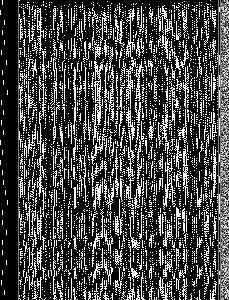

In [14]:
img
#img.resize((239, 600))

In [15]:
log['loop']['control'].mean()

tensor(0.2873, grad_fn=<MeanBackward0>)

In [16]:
log['loop']['mem'].mean()



tensor(0.5197, grad_fn=<MeanBackward0>)

In [17]:
model.model.layers.loop.model.layers.control_synapse.weight.var()

tensor(0.0116, grad_fn=<VarBackward0>)

In [18]:
model.model.layers.loop.model.layers.mem_synapse.weight.var()

tensor(0.0040, grad_fn=<VarBackward0>)

In [19]:
model.model.layers.loop.model.layers.control_synapse.weight.var() * log['loop']['mem'].mean()


tensor(0.0060, grad_fn=<MulBackward0>)

In [20]:
#model.save('../models/state_adaptive1')

In [21]:
lookup

tensor([[6, 1, 4, 5, 7, 2, 0, 3],
        [7, 0, 4, 2, 3, 1, 5, 6],
        [0, 5, 6, 2, 4, 3, 7, 1],
        [2, 7, 6, 4, 3, 1, 5, 0],
        [0, 6, 4, 5, 2, 1, 7, 3],
        [5, 1, 0, 6, 4, 7, 3, 2],
        [4, 6, 1, 2, 5, 7, 0, 3],
        [2, 7, 4, 3, 5, 6, 0, 1]])